# 项目可视化 Notebook

本 notebook 用于可视化项目的运行结果。

In [1]:
import os
from ortools.constraint_solver import routing_enums_pb2, pywrapcp
import pickle
import re
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
import torch
import logging

from utils import *
from data_visualize import *
from partitioner_solver_utils import *

## 数据说明

1. **基本VRP变体**
   - CVRP: 带容量约束的车辆路径问题
   - OVRP: 开放车辆路径问题（车辆不需要返回仓库）
   - VRPB: 带后向配送的车辆路径问题
   - OVRPB: 开放带后向配送的车辆路径问题

2. **带时间窗的VRP变体**
   - VRPTW: 带时间窗的车辆路径问题
   - OVRPTW: 开放带时间窗的车辆路径问题
   - VRPBTW: 带后向配送和时间窗的车辆路径问题
   - OVRPBTW: 开放带后向配送和时间窗的车辆路径问题

3. **带路线长度限制的VRP变体**
   - VRPL: 带路线长度限制的车辆路径问题
   - OVRPL: 开放带路线长度限制的车辆路径问题
   - VRPBL: 带后向配送和路线长度限制的车辆路径问题
   - OVRPBL: 开放带后向配送和路线长度限制的车辆路径问题

4. **带时间窗和路线长度限制的VRP变体**
   - VRPLTW: 带时间窗和路线长度限制的车辆路径问题
   - OVRPLTW: 开放带时间窗和路线长度限制的车辆路径问题
   - VRPBLTW: 带后向配送、时间窗和路线长度限制的车辆路径问题
   - OVRPBLTW: 开放带后向配送、时间窗和路线长度限制的车辆路径问题

每种变体的数据格式：
- 基本数据：仓库坐标、客户点坐标、需求、车辆容量
- 时间窗数据：服务时间、时间窗开始时间、时间窗结束时间
- 路线长度限制：最大路线长度
- 后向配送：需求为负值，表示需要从客户点取货

>> Load 1000 data (<class 'list'>) from ./data/CVRP/cvrp200_uniform.pkl
CVRP问题数据:
([[0.6301724314689636, 0.5674986243247986]], [[0.948992133140564, 0.9370192885398865], [0.1760135442018509, 0.8455002307891846], [0.9993495941162109, 0.2346317619085312], [0.9259338974952698, 0.6811452507972717], [0.7786675095558167, 0.3427703082561493], [0.9951274394989014, 0.05549748241901398], [0.0014417223865166306, 0.9780272841453552], [0.15227195620536804, 0.9888145327568054], [0.9019197821617126, 0.4663983881473541], [0.11837667971849442, 0.9632952213287354], [0.2915337085723877, 0.8843126893043518], [0.48606008291244507, 0.7037550210952759], [0.8239096403121948, 0.9138471484184265], [0.38201120495796204, 0.15965034067630768], [0.30926692485809326, 0.06266481429338455], [0.08193419873714447, 0.867408812046051], [0.5822877883911133, 0.9796773195266724], [0.23337875306606293, 0.8833986520767212], [0.28196167945861816, 0.5860730409622192], [0.351036012172699, 0.9999664425849915], [0.5547016859054565, 

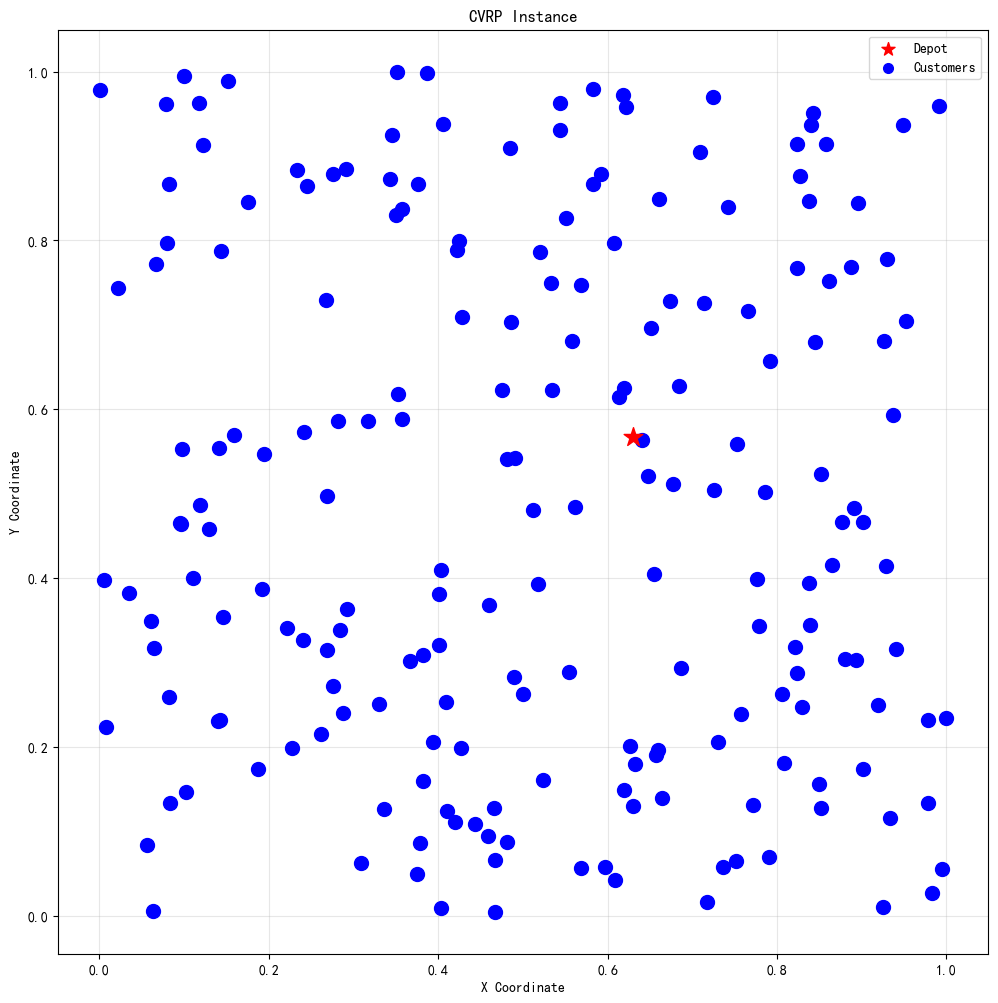

NameError: name 'solution' is not defined

In [9]:
# 可视化VRP问题
instance_number = 0
dataset_path = './data/CVRP/cvrp200_uniform.pkl'
instance = load_dataset(dataset_path)[instance_number]
try:
    # solution_path = './data/CVRP/or_tools_20s_cvrp50_uniform.pkl'
    solution = load_dataset(solution_path)[instance_number]
except:
    pass

# 使用正则表达式提取问题类型
match = re.search(r'/data/([A-Z]+)/', dataset_path)
if match:
    problem_type = match.group(1)
else:
    raise ValueError("无法从 dataset_path 中提取问题名称")

print(f'{problem_type}问题数据:\n{instance}\n')

# 打印实例信息
print_vrp_instance_info(instance, problem_type)

# 可视化实例
visualize_vrp_instance(instance, problem_type)

if solution:
    print(f'{problem_type}解数据:\n{solution}\n')

    # 可视化VRP问题的解
    visualize_solution(instance, solution, problem_type) 

CVRP problem best solution with OR-TOOLS solving for 5s :
(21.58011, [91, 124, 170, 103, 20, 8, 10, 48, 104, 7, 16, 133, 2, 0, 184, 92, 70, 15, 99, 166, 197, 75, 41, 80, 93, 187, 55, 67, 0, 12, 98, 148, 143, 106, 111, 62, 117, 115, 153, 0, 31, 56, 49, 50, 112, 42, 176, 141, 109, 169, 162, 137, 132, 0, 24, 54, 45, 140, 14, 174, 58, 198, 130, 147, 26, 68, 30, 0, 74, 102, 83, 40, 27, 145, 129, 60, 38, 34, 21, 0, 173, 121, 144, 172, 190, 18, 149, 11, 81, 142, 39, 150, 182, 156, 0, 171, 101, 72, 167, 178, 46, 57, 13, 90, 1, 66, 181, 4, 0, 123, 36, 9, 53, 177, 131, 128, 200, 28, 196, 3, 183, 89, 23, 193, 0, 71, 122, 151, 64, 189, 69, 29, 6, 134, 161, 118, 191, 152, 5, 51, 0, 73, 44, 35, 108, 139, 116, 86, 107, 59, 47, 110, 125, 0, 95, 78, 126, 105, 179, 33, 186, 180, 32, 158, 97, 127, 146, 159, 165, 63, 0, 52, 119, 37, 136, 195, 120, 96, 17, 199, 65, 88, 155, 0, 164, 114, 76, 185, 192, 43, 87, 113, 61, 188, 77, 175, 0, 25, 154, 19, 168, 160, 138, 94, 100, 85, 22, 157, 82, 0, 135, 163, 194, 7

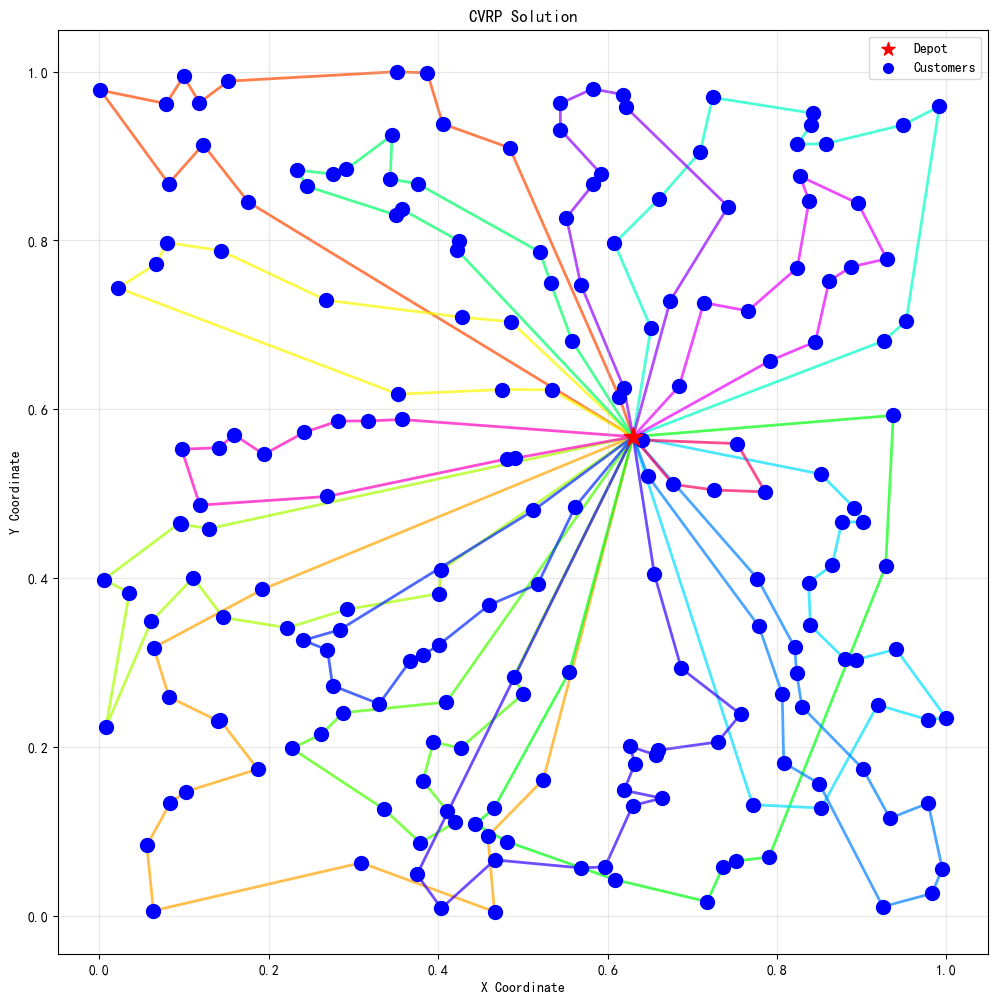

In [10]:
from ortools_solver import ortools_solve_vrp

timelimit = 5

or_tools_solution = ortools_solve_vrp(instance, problem_type, timelimit)
print(f'{problem_type} problem best solution with OR-TOOLS solving for {timelimit}s :\n{or_tools_solution}')

visualize_solution(instance, or_tools_solution, problem_type) 

In [6]:
# Cell 1: Load the Pre-trained Solver Model

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

pretrained_model_name = "mvmoe_8e_n50"
checkpoint_path = f"D:/Data-Proccess/pretrained/{pretrained_model_name}/epoch-2500.pt" # Use forward slashes or raw string
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded_solver_model = load_moe_model(
    checkpoint_path=checkpoint_path,
    device=device,
)

INFO: Attempting to load model from checkpoint: D:/Data-Proccess/pretrained/mvmoe_4e_n100/epoch-5000.pt
INFO: Inferred model type as MOE from path.
INFO: Using default model parameters initially.
INFO: Inferred num_experts=4 from checkpoint path.
INFO: >> Checkpoint loaded successfully. Epoch: 5000
INFO: >> Using problem type 'Train_ALL' from checkpoint (top-level) for model instantiation.
INFO: >> Model state_dict loaded successfully (strict=True).
INFO: >> Model set to evaluation mode.


In [7]:
# Cell 2: Prepare Data and Solve the Instance

# --- Get Environment Class ---
EnvClassList = get_env(problem_type)
if not EnvClassList:
    raise ValueError(f"Could not get environment class for problem type: {problem_type}")
solver_env_class = EnvClassList[0]
print(f"Using environment: {solver_env_class.__name__}")


# --- Prepare Instance Data ---
# 1. Pad the single instance
# Note: For solving a single instance, padding target can be solver_native_size
# The pad_subproblem_batch function handles the hybrid strategy, which is fine here too.
padded_batch_tuples, target_pad_size = pad_subproblem_batch(
    [instance], problem_type
)

print(f"Instance padded to size: {target_pad_size}")


padded_batch_tensor_data = prepare_batch_tensor_data(
    padded_batch_tuples, problem_type, device
)


# --- Solve the Instance ---
print("Calling solve_vrp_batch...")

solver_results = solve_vrp_batch(
    solver_model=loaded_solver_model,
    solver_env_class=solver_env_class,
    original_instance_tuples=[instance], # Pass original instance in a list
    padded_batch_data=padded_batch_tensor_data,
    padded_problem_size=target_pad_size,
    problem_type=problem_type,
    device=device
)

# --- Extract Solution ---
if solver_results and len(solver_results) == 1:
    aug_score, best_aug_path_list = solver_results[0]
    if aug_score != float('inf'):
        print(f"Solving successful. Augmented Score: {aug_score:.4f}")
        if best_aug_path_list:
            reconstructed_path = [0] # Start at depot
            current_route = []
            print(f"Best augmented path (nodes): {best_aug_path_list}")
            aug_sol_for_viz = (aug_score, [0] + best_aug_path_list + [0] if best_aug_path_list else [0, 0])
        else:
            print("Best augmented path not available.")
            aug_sol_for_viz = (aug_score, [0, 0]) # Placeholder path

        visualize_solution(instance, aug_sol_for_viz, problem_type) # Use the reconstructed/adapted solution

    else:
        print("Solving failed (Infinite score).")
else:
    print("Solving failed (No results returned or incorrect format).")


Using environment: CVRPEnv
Instance padded to size: 5000
Calling solve_vrp_batch...


ERROR: Error during solve_vrp_batch execution: CUDA out of memory. Tried to allocate 5.96 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 13.54 GiB is allocated by PyTorch, and 12.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Traceback (most recent call last):
  File "d:\Data-Proccess\partitioner_solver_utils.py", line 536, in solve_vrp_batch
    solver_model.pre_forward(reset_state)
  File "d:\Data-Proccess\models\MOEModel.py", line 42, in pre_forward
    self.encoded_nodes, moe_loss = self.encoder(depot_xy, node_xy_demand_tw)
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\anaconda3\envs\mtvrp\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapp

Solving failed (Infinite score).


INFO: Partitioning instance (type: CVRP) using fine-tuned model: results\TAM_MoE\MOE_4e_CVRP_n200_20250425_050856\40.pt
INFO: Attempting to load model from checkpoint: results\TAM_MoE\MOE_4e_CVRP_n200_20250425_050856\40.pt
INFO: Using provided model type: MOE
INFO: Using provided model parameters.
INFO: >> Checkpoint loaded successfully. Epoch: 40
INFO: >> Using problem type 'CVRP' from checkpoint args for model instantiation.
INFO: >> Model state_dict loaded successfully (strict=True).
INFO: >> Model set to evaluation mode.
INFO: Instance size N=50, Max sequence length set to 102
INFO: Generated raw sequence (len=59): [0, 1, 13, 2, 41, 19, 48, 37, 43, 6, 18, 0, 27, 35, 26, 50, 17, 14, 40, 38]...
INFO: Successfully created 3 final subproblem instances after weighted polar merging.


=== Visualizing Partitioned CVRP Instance ===
Number of subproblems: 3


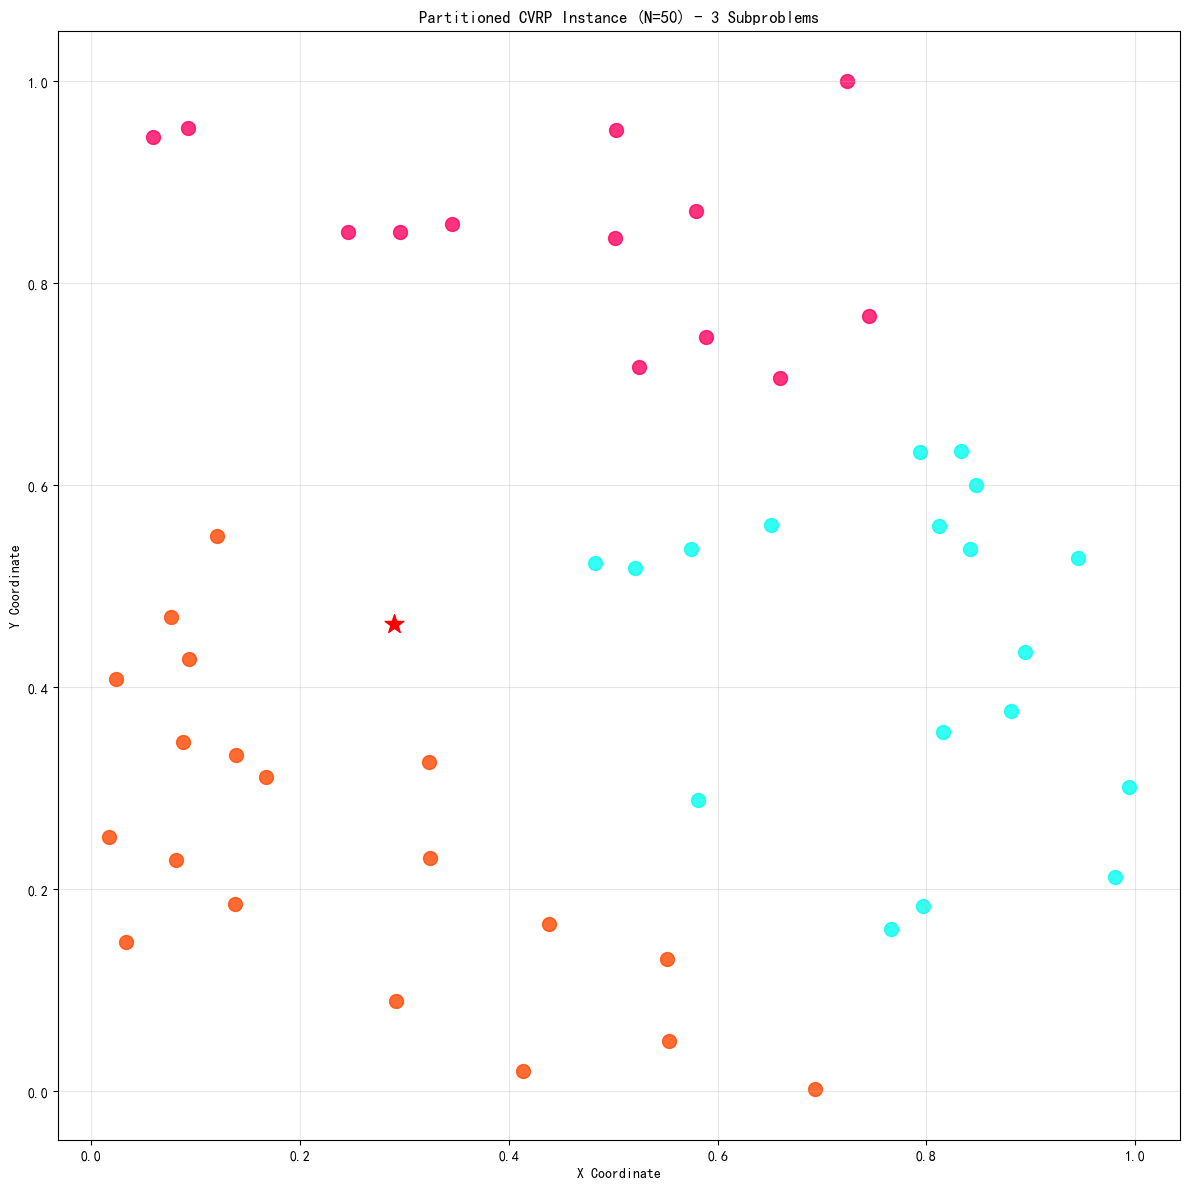

In [6]:
partitioner_checkpoint_path = os.path.join('results', 'TAM_MoE', 'MOE_4e_CVRP_n200_20250425_050856', '40.pt')
merge_num = 3

partitioner_model_params = DEFAULT_MODEL_PARAMS.copy()
partitioner_model_params['num_experts'] = 4
partitioner_model_params['problem'] = problem_type
partitioner_model_params['model_type'] = "MOE"

# Call the partitioning function
subproblem_tuples, raw_partition_sequence = partition_instance(
    original_instance_tuple=instance,
    problem_type=problem_type,
    partitioner_checkpoint_path=partitioner_checkpoint_path,
    merge_num=merge_num,
    device=device,
    partitioner_model_params=partitioner_model_params # Pass the architecture params
)

visualize_partitioned_instance(
    original_instance=instance,
    subproblem_tuples=subproblem_tuples,
    problem_type=problem_type
)


Processing subproblem results:
  Subproblem 1: Score=3.242115020751953, Path Nodes=[8, 7, 16, 15, 14, 17, 0, 1, 2, 3, 4, 5, 6, 13, 0, 11, 12, 10, 9, 18, 19]
  Subproblem 2: Score=3.5365450382232666, Path Nodes=[1, 4, 3, 5, 6, 7, 2, 0, 8, 9, 10, 11, 15, 14, 13, 16, 17, 12, 0, 18, 19]
  Subproblem 3: Score=2.948090076446533, Path Nodes=[8, 7, 6, 5, 4, 2, 3, 1, 0, 13, 12, 11, 10, 9, 0, 14, 15, 16, 17, 18, 19]

--- Merging 3 instances ---
--- Merging corresponding solutions ---
>> Detected structure: Has_L=False, Has_TW=False, Expected Len=4
>> Merged instance created with 57 total nodes.
>> Merged solution created: Total Score=9.7268, Path Length=65
=== Solution Information ===
Solution Score: 9.7268
Number of Routes: 9


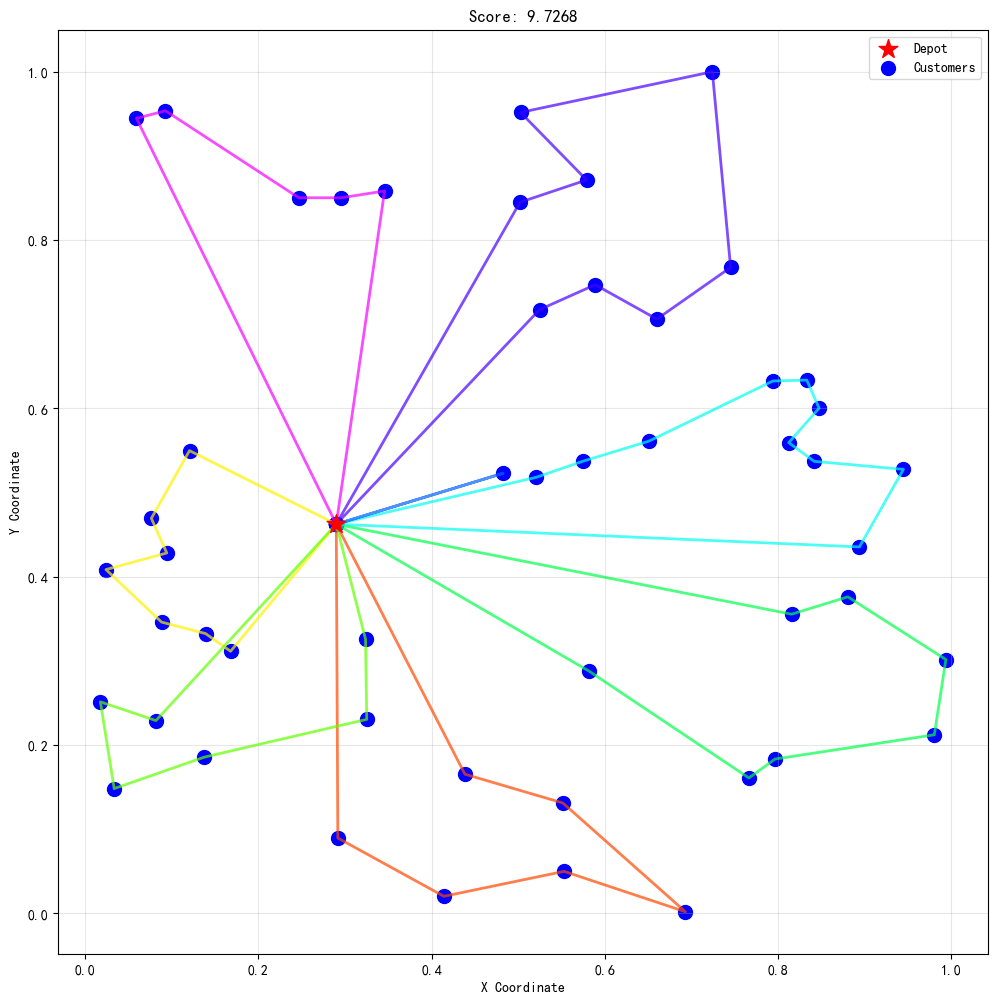

In [7]:
# Solve Subproblems in Parallel (Batch) and Visualize Combined Solution

import math # For checking float('inf')

# --- Prepare Subproblem Batch Data ---
# Pad the batch of subproblems. Target size determined by the function.
padded_subproblem_batch_tuples, subproblem_target_pad_size = pad_subproblem_batch(subproblem_tuples, problem_type)
# Convert to tensors
padded_subproblem_batch_tensor_data = prepare_batch_tensor_data( padded_subproblem_batch_tuples, problem_type, device)

# --- Solve the Subproblem Batch ---
# solve_vrp_batch already processes the list as a batch
subproblem_solver_results = solve_vrp_batch(
    solver_model=loaded_solver_model,
    solver_env_class=solver_env_class,
    original_instance_tuples=subproblem_tuples, # Pass the original subproblem tuples
    padded_batch_data=padded_subproblem_batch_tensor_data,
    padded_problem_size=subproblem_target_pad_size,
    problem_type=problem_type,
    device=device
)

# --- Process ---
print("\nProcessing subproblem results:")
for i, result in enumerate(subproblem_solver_results):
    sub_score, sub_path_nodes = result
    print(f"  Subproblem {i+1}: Score={sub_score if sub_score != float('inf') else 'FAIL'}, Path Nodes={sub_path_nodes}")

merged_instance_1, merged_solution_1 = merge_solved_instances(padded_subproblem_batch_tuples, subproblem_solver_results)
visualize_solution(merged_instance_1, merged_solution_1, problem_type)